# CDR for quantum dynamics
- TFIM Hamiltonian (constants not site-dependent) evolving with TDSE
- discretize the evolution steps and use first-order Trotter decomposition 

### Idea:
- get plain CDR running for Dynamics and benchmark
- check accuracy of CDR vs runtime/step division (problem is small step division, not runtime)
- add perturbation approach (all non-Cliffords) if necessary
- add noise levels (data augmentation) if necessary



In [1]:
using PauliPropagation
using Random
using Optim
using Plots
using ReverseDiff: GradientTape, gradient!, compile, gradient
using LinearAlgebra
using StatsBase 
using GLM
using DataFrames
using CSV
using Format
using Logging
using Distributions
using LaTeXStrings
Random.seed!(43)

TaskLocalRNG()

In [2]:
struct UnbufferedLogger <: Logging.AbstractLogger
    stream::IO
    level::Logging.LogLevel
end

const MainInfo = Base.CoreLogging.LogLevel(200)
const SubInfo = Base.CoreLogging.LogLevel(100)

const LOG_LEVEL_NAMES = Dict(
    Logging.Debug => "Debug",
    Logging.Info => "Info",
    Logging.Warn => "Warn",
    Logging.Error => "Error",
    SubInfo => "SubInfo",
    MainInfo => "MainInfo"
)

Logging.min_enabled_level(logger::UnbufferedLogger) = logger.level
Logging.shouldlog(logger::UnbufferedLogger, level, _module, group, id) = level ≥ logger.level
Logging.catch_exceptions(::UnbufferedLogger) = true

function Logging.handle_message(logger::UnbufferedLogger, level, message, _module, group, id, file, line; kwargs...)
    level_name = get(LOG_LEVEL_NAMES, level, "$level")  # Default for custom levels
    print(logger.stream, "[$level_name] ", message, "\n")  # Include log level
    flush(logger.stream)  # Ensure immediate output
end


global_logger(UnbufferedLogger(stdout, SubInfo))

Base.CoreLogging.SimpleLogger(VSCodeServer.IJuliaCore.IJuliaStdio{Base.PipeEndpoint, typeof(VSCodeServer.io_send_callback)}(IOContext(Base.PipeEndpoint(RawFD(31) open, 0 bytes waiting)), VSCodeServer.io_send_callback), Info, Dict{Any, Int64}())

In [3]:
struct trotter_ansatz_tfim
    target_circuit::Vector{Gate}
    target_circuit_layer::Vector{Gate}
    topology::Vector{Tuple{Int64, Int64}}
    nqubits::Integer
    steps::Integer #layers
    time::Float64
    J::Float64
    h::Float64
    sigma_J::Float64
    sigma_h::Float64
    sigma_J_indices::Vector{Int64}
    sigma_h_indices::Vector{Int64}
    sigma_J_indices_layer::Vector{Int64}
    sigma_h_indices_layer::Vector{Int64}
end

function trotter_setup(nqubits::Integer, steps::Integer, time::Float64, J::Float64, h::Float64;topology = nothing)
    if isnothing(topology)
        topology = bricklayertopology(nqubits)
    end
    target_circuit = tfitrottercircuit(nqubits,steps,topology=topology) #starts with RZZ layer
    target_circuit_layer = tfitrottercircuit(nqubits,1,topology=topology) #starts with RZZ layer
    sigma_J = -2*T*J/steps
    sigma_h = 2*T*h/steps 

    sigma_J_indices = getparameterindices(target_circuit, PauliRotation, [:Z,:Z]) 
    sigma_h_indices = getparameterindices(target_circuit, PauliRotation, [:X])
    
    sigma_J_indices_layer = getparameterindices(target_circuit_layer, PauliRotation, [:Z,:Z])
    sigma_h_indices_layer = getparameterindices(target_circuit_layer, PauliRotation, [:X])
    
    return trotter_ansatz_tfim(target_circuit,target_circuit_layer, topology, nqubits, steps, time, J, h,sigma_J, sigma_h,sigma_J_indices, sigma_h_indices, sigma_J_indices_layer, sigma_h_indices_layer)
end

trotter_setup (generic function with 1 method)

In [4]:
function constrain_params(ansatz; layer=false)
    """
    Set all RX gates and all RZZ gates to have the same parameter value respectively.
    """
    if layer
        nparams = countparameters(ansatz.target_circuit_layer)
        thetas = zeros(nparams)
        thetas[ansatz.sigma_h_indices_layer] .= ansatz.sigma_h
        thetas[ansatz.sigma_J_indices_layer] .= ansatz.sigma_J
    else
        nparams = countparameters(ansatz.target_circuit)
        thetas = zeros(nparams)
        thetas[ansatz.sigma_h_indices] .= ansatz.sigma_h
        thetas[ansatz.sigma_J_indices] .= ansatz.sigma_J
    end
    
    return thetas
end

constrain_params (generic function with 1 method)

In [5]:
function obs_interaction(ansatz)
    interaction = PauliSum(ansatz.nqubits)
    
    for i in 1:length(ansatz.topology)
        q1 = ansatz.topology[i][1]
        q2 = ansatz.topology[i][2]
        add!(interaction, [:Z, :Z], [q1, q2])
    end
    return interaction/length(ansatz.topology)
end

obs_interaction (generic function with 1 method)

In [6]:
function obs_magnetization(ansatz)
    """
    Returns the normalised magnetization.
    """
    magnetization = PauliSum(ansatz.nqubits)
    for i in 1:nq
        add!(magnetization,:Z,i)
    end
    magnetization = magnetization/nq
    return magnetization
end

obs_magnetization (generic function with 1 method)

In [7]:
function training_set_generation_brut(ansatz::trotter_ansatz_tfim, angle_definition::Float64=pi/2; num_samples::Int = 10, non_replaced_gates::Int = 30)
    """
    Generates a training set of thetas for the ansatz. The training set is generated by selecting a number of cliffords and non-cliffords
    and setting the corresponding thetas to multiples of angle_definition. 
    """
    nparams = countparameters(ansatz.target_circuit)
    replaced_gates = nparams - non_replaced_gates
    ratio = length(ansatz.sigma_J_indices)/(length(ansatz.sigma_h_indices)+length(ansatz.sigma_J_indices))
    num_h = Int(round((1-ratio)*replaced_gates))
    num_J = Int(round(ratio*replaced_gates))
    training_thetas_list = Vector{Vector{Float64}}()
    thetas = constrain_params(ansatz)
    k_h =round(ansatz.sigma_h/(angle_definition))
    k_J =round(ansatz.sigma_J/(angle_definition))
    
    
    for _ in 1:num_samples
        training_thetas = deepcopy(thetas)
        shuffled_sigma_h_indices =  Random.shuffle!(ansatz.sigma_h_indices)
        shuffled_sigma_J_indices = Random.shuffle!(ansatz.sigma_J_indices)
        selected_indices_h = shuffled_sigma_h_indices[1:num_h]
        selected_indices_J = shuffled_sigma_J_indices[1:num_J]

        for i in selected_indices_h
            training_thetas[i] = k_h*angle_definition
        end
        for i in selected_indices_J
            training_thetas[i] = k_J*angle_definition
        end
        push!(training_thetas_list, training_thetas)
    end
    return training_thetas_list
end

training_set_generation_brut (generic function with 2 methods)

In [8]:
function training_set_generation_strict_perturbation(ansatz::trotter_ansatz_tfim,sigma_star::Float64=pi/20; sample_function = nothing, num_samples::Int = 10)
    """
    Generates a training set according to the CPA approach. We do not use data augmentation here and stick to standard CPA.
    Their bound holds only if we replace all gates (we can't keep original gates).
    """
    function sample_theta_CPA(sigma_star)
        # sig_h ∈ [0, sigma_star] ∪ [π/2 - sigma_star, π/2]
        sig_h = rand(Bool) ? rand(Uniform(0.0, sigma_star)) : rand(Uniform(π/2 - sigma_star, π/2))
    
        # sig_J ∈ [−sigma_star, 0] ∪ [−π/2, −π/2 + sigma_star]
        sig_J = rand(Bool) ? rand(Uniform(-sigma_star, 0.0)) : rand(Uniform(-π/2, -π/2 + sigma_star))
    
        return sig_h, sig_J
    end

    function sample_theta_small(sigma_star)
        # sig_h ∈ [0, sigma_star] ∪ [π/2 - sigma_star, π/2]
        sig_h =  rand(Uniform(0.0, sigma_star)) 
    
        # sig_J ∈ [−sigma_star, 0] ∪ [−π/2, −π/2 + sigma_star]
        sig_J = rand(Uniform(-sigma_star, 0.0))
    
        return sig_h, sig_J
    end
    
    if sample_function == nothing
        sample_function = sample_theta_CPA
    elseif sample_function == "CPA"
        sample_function = sample_theta_CPA
    elseif sample_function == "small"
        sample_function = sample_theta_small
    end


    training_thetas_list = Vector{Vector{Float64}}()
    thetas = constrain_params(ansatz)
    training_thetas = deepcopy(thetas)
    
    for _ in 1:num_samples
        sig_h_perturbed, sig_J_perturbed = sample_function(sigma_star)
        training_thetas[ansatz.sigma_h_indices] .= sig_h_perturbed
        training_thetas[ansatz.sigma_J_indices] .= sig_J_perturbed
        push!(training_thetas_list, copy(training_thetas))
    
    end

    return training_thetas_list
end

training_set_generation_strict_perturbation (generic function with 2 methods)

In [9]:
function training_set_generation_loose_perturbation(ansatz::trotter_ansatz_tfim,sigma_star::Float64=pi/20; sample_function = nothing, num_samples::Int = 10)
    """
    Generates a training set according to the CPA approach. We do not use data augmentation here and stick to standard CPA.
    Their bound holds only if we replace all gates (we can't keep original gates).
    """

    if !(0.0 <= ansatz.sigma_h <= sigma_star) && !(pi/2 - sigma_star <= ansatz.sigma_h <= pi/2)
        change_sigma_h = true
    else
        change_sigma_h = false
    end
    if !(-sigma_star <= ansatz.sigma_J <= 0.0) && !(-pi/2 <= ansatz.sigma_J <= -pi/2 + sigma_star)
        change_sigma_J = true
    else
        change_sigma_J = false
    end
    
    function sample_theta_CPA(sigma_star)
        # sig_h ∈ [0, sigma_star] ∪ [π/2 - sigma_star, π/2]
        sig_h = rand(Bool) ? rand(Uniform(0.0, sigma_star)) : rand(Uniform(π/2 - sigma_star, π/2))
    
        # sig_J ∈ [−sigma_star, 0] ∪ [−π/2, −π/2 + sigma_star]
        sig_J = rand(Bool) ? rand(Uniform(-sigma_star, 0.0)) : rand(Uniform(-π/2, -π/2 + sigma_star))
    
        return sig_h, sig_J
    end

    function sample_theta_small(sigma_star)
        # sig_h ∈ [0, sigma_star] ∪ [π/2 - sigma_star, π/2]
        sig_h =  rand(Uniform(0.0, sigma_star)) 
    
        # sig_J ∈ [−sigma_star, 0] ∪ [−π/2, −π/2 + sigma_star]
        sig_J = rand(Uniform(-sigma_star, 0.0))
    
        return sig_h, sig_J
    end
    
    if sample_function == nothing
        sample_function = sample_theta_small
    elseif sample_function == "CPA"
        sample_function = sample_theta_CPA
    elseif sample_function == "small"
        sample_function = sample_theta_small
    end


    training_thetas_list = Vector{Vector{Float64}}()
    thetas = constrain_params(ansatz)
    training_thetas = deepcopy(thetas)
    
    for _ in 1:num_samples
        if change_sigma_h
            sig_h_perturbed, _ = sample_function(sigma_star)
        else 
            sig_h_perturbed = ansatz.sigma_h
        end
        if change_sigma_J
            _, sig_J_perturbed = sample_function(sigma_star)
        else 
            sig_J_perturbed = ansatz.sigma_J
        end
        training_thetas[ansatz.sigma_h_indices] .= sig_h_perturbed
        training_thetas[ansatz.sigma_J_indices] .= sig_J_perturbed
        push!(training_thetas_list, copy(training_thetas))
    
    end

    return training_thetas_list
end

training_set_generation_loose_perturbation (generic function with 2 methods)

In [10]:
function trotter_time_evolution(ansatz; observable = nothing, special_thetas=nothing, noise_kind="noiseless", record=false, min_abs_coeff=0.0, depol_strength=0.01, dephase_strength=0.01,depol_strength_double=0.0033, dephase_strength_double=0.0033) 
    """
    Function that computes the time evolution of the ansatz using the first order Trotter approximation exact time evolution operator.
    The function returns the overlap of the final state with the |0> state.
    """
    if observable==nothing
        obs = obs_interaction(ansatz)
    else
        obs = deepcopy(observable)
    end

    if special_thetas==nothing
        thetas = constrain_params(ansatz)
    else
        thetas = special_thetas
    end

    if noise_kind=="naive"
        if record
            error("Naive noise model doesn't support recording :(")
        else
            circuit = final_noise_layer_circuit(ansatz; depol_strength, dephase_strength)
        end
    elseif noise_kind=="gate"
        circuit = gate_noise_circuit(ansatz; depol_strength, dephase_strength, layer=record)
    elseif noise_kind=="noiseless"
        if record
            circuit = ansatz.target_circuit_layer
        else
            circuit = ansatz.target_circuit
        end
    elseif noise_kind=="realistic"
        circuit = realistic_gate_noise_circuit(ansatz; depol_strength_single = depol_strength, dephase_strength_single = dephase_strength, depol_strength_double = depol_strength_double, dephase_strength_double = dephase_strength_double, layer=record)
        
    else
        error("Noise kind $(noise_kind) unknown.")
    end

    if record
        nparams = countparameters(ansatz.target_circuit)
        expvals_trotter = Float64[]   
        push!(expvals_trotter, overlapwithzero(obs))
        for i in 1:ansatz.steps
            psum = propagate!(circuit, obs, thetas[Int(nparams/ansatz.steps*(i-1)+1):Int(nparams/ansatz.steps*i)];min_abs_coeff=min_abs_coeff)
            push!(expvals_trotter, overlapwithzero(psum))
        end
        return expvals_trotter  
    else 
        psum = propagate!(circuit, obs,  thetas; min_abs_coeff=min_abs_coeff)
        return overlapwithzero(psum)
    end
end

trotter_time_evolution (generic function with 1 method)

In [11]:
function training_trotter_time_evolution(ansatz::trotter_ansatz_tfim, training_thetas::Vector{Vector{Float64}};observable = nothing, noise_kind="noiseless", min_abs_coeff=0.0, depol_strength=0.01, dephase_strength=0.01, depol_strength_double=0.0033, dephase_strength_double=0.0033, record=false)
    """
    Function that computes the time evolution of the ansatz using the first order Trotter approximation exact time evolution operator.
    The function returns the overlap of the final state with the |0> state.
    """
    if record 
        exact_expvals = Vector{Vector{Float64}}()
    else
        exact_expvals = Vector{Float64}()
    end
    for thetas in training_thetas
        push!(exact_expvals, trotter_time_evolution(ansatz; observable = observable, record=record, special_thetas=thetas, noise_kind=noise_kind, min_abs_coeff=min_abs_coeff, depol_strength=depol_strength, dephase_strength=dephase_strength, depol_strength_double=depol_strength_double, dephase_strength_double=dephase_strength_double))
    end
    return exact_expvals
end

training_trotter_time_evolution (generic function with 1 method)

In [12]:
function final_noise_layer_circuit(ansatz; depol_strength=0.05, dephase_strength=0.05)
    """
    Function that adds a final layer of depolarizing and dephasing noise to the ansatz.
    """
    depol_noise_layer = [DepolarizingNoise(qind, depol_strength ) for qind in 1:ansatz.nqubits];
    dephase_noise_layer = [DephasingNoise(qind, dephase_strength) for qind in 1:ansatz.nqubits];
    noisy_circuit = deepcopy(ansatz.target_circuit)
    append!(noisy_circuit,depol_noise_layer)
    append!(noisy_circuit,dephase_noise_layer)

    return noisy_circuit
end

function gate_noise_circuit(ansatz; depol_strength=0.01, dephase_strength=0.01, start_with_ZZ=true, layer=false)
    """
    Noise model from the CPA paper, where we add a layer of depolarizing and dephasing noise after each step/layer of the ansatz.
    """
    circuit::Vector{Gate} = []
    if layer
        steps = 1
    else
        steps = ansatz.steps
    end

    # the function after this expects a circuit with at least one layer and will always append something
    if steps<1
        error("The number of steps should be at least 1 (steps=$steps).")
    end

    depol_noise_layer = [DepolarizingNoise(qind, depol_strength ) for qind in 1:ansatz.nqubits];
    phase_damp_layer = [DephasingNoise(qind, dephase_strength) for qind in 1:ansatz.nqubits];

    if start_with_ZZ
        rzzlayer!(circuit, ansatz.topology)
        append!(circuit, depol_noise_layer)
        append!(circuit, phase_damp_layer)
    end

    for _ in 1:steps-1
        rxlayer!(circuit, ansatz.nqubits)
        append!(circuit, depol_noise_layer)
        append!(circuit, phase_damp_layer)
        rzzlayer!(circuit, ansatz.topology)
        append!(circuit, depol_noise_layer)
        append!(circuit, phase_damp_layer)
    end

    rxlayer!(circuit, ansatz.nqubits)
    append!(circuit, depol_noise_layer)
    append!(circuit, phase_damp_layer)

    if !start_with_ZZ
        rzzlayer!(circuit, ansatz.topology)
        append!(circuit, depol_noise_layer)
        append!(circuit, phase_damp_layer)
    end

    return circuit
end

function realistic_gate_noise_circuit(ansatz; depol_strength_double=0.0033, dephase_strength_double=0.0033, depol_strength_single=0.00035, dephase_strength_single=0.00035, start_with_ZZ=true, layer=false)
    """
    Noise model from the CPA paper, where we add a layer of depolarizing and dephasing noise after each step/layer of the ansatz.
    """
    circuit::Vector{Gate} = []
    if layer
        steps = 1
    else
        steps = ansatz.steps
    end

    # the function after this expects a circuit with at least one layer and will always append something
    if steps<1
        error("The number of steps should be at least 1 (steps=$steps).")
    end

    depol_noise_layer_single = [DepolarizingNoise(qind, depol_strength_single ) for qind in 1:ansatz.nqubits];
    phase_damp_layer_single = [DephasingNoise(qind, dephase_strength_single) for qind in 1:ansatz.nqubits];
    depol_noise_layer_double = [DepolarizingNoise(qind, depol_strength_double ) for qind in 1:ansatz.nqubits];
    phase_damp_layer_double = [DephasingNoise(qind, dephase_strength_double) for qind in 1:ansatz.nqubits];

    if start_with_ZZ
        rzzlayer!(circuit, ansatz.topology)
        append!(circuit, depol_noise_layer_double)
        append!(circuit, phase_damp_layer_double)
        
    end

    for _ in 1:steps-1
        rxlayer!(circuit, ansatz.nqubits)
        append!(circuit, depol_noise_layer_single)
        append!(circuit, phase_damp_layer_single)
        rzzlayer!(circuit, ansatz.topology)
        append!(circuit, depol_noise_layer_double)
        append!(circuit, phase_damp_layer_double)
    end

    rxlayer!(circuit, ansatz.nqubits)
    append!(circuit, depol_noise_layer_single)
    append!(circuit, phase_damp_layer_single)

    if !start_with_ZZ
        rzzlayer!(circuit, ansatz.topology)
        append!(circuit, depol_noise_layer_double)
        append!(circuit, phase_damp_layer_double)
    end

    return circuit
end

realistic_gate_noise_circuit (generic function with 1 method)

In [13]:
function cdr(noisy_exp_values::Vector{Float64}, exact_exp_values::Vector{Float64}, noisy_target_exp_value::Float64, exact_target_exp_value::Float64)
    training_data = DataFrame(x=noisy_exp_values,y=exact_exp_values)
    ols = lm(@formula(y ~ x), training_data)
    function cdr_em(x)
        return  coef(ols)[1] + coef(ols)[2] * x
    end
    rel_error_after = abs(exact_target_exp_value - cdr_em(noisy_target_exp_value)) / abs(exact_target_exp_value)
    rel_error_before = abs(exact_target_exp_value - noisy_target_exp_value) / abs(exact_target_exp_value)
    
    @debug training_data
    @logmsg SubInfo "Noisy target expectation value: $(noisy_target_exp_value)"
    @logmsg SubInfo "Relative error before CDR: $(rel_error_before)"
    @logmsg SubInfo "CDR-EM target expectation value: $(cdr_em(noisy_target_exp_value))"
    @logmsg SubInfo "Relative error after CDR: $(rel_error_after)"
    return cdr_em(noisy_target_exp_value), rel_error_after, rel_error_before
end 

cdr (generic function with 1 method)

In [14]:
function full_run(ansatz, angle_definition, noise_kind, min_abs_coeff, min_abs_coeff_noisy;training_set = nothing, observable = nothing, num_samples=10, non_replaced_gates=30,depol_strength=0.01, dephase_strength=0.01,depol_strength_double=0.0033, dephase_strength_double=0.0033)
    """
    # for CPA, the angle_definition is the sigma_star value
    """
    @logmsg SubInfo "ready to ruuuuuummmble"


    if observable==nothing || observable == obs_interaction(ansatz)
        observable = obs_interaction(ansatz)
        obs_string = "ZZ"
    elseif observable == obs_magnetization(ansatz)
        obs_string = "Z"
    end

    if training_set == nothing 
        training_set = training_set_generation_strict_perturbation(ansatz, angle_definition; num_samples=num_samples)
    end 


    time1 = time()
    exact_expval_target = trotter_time_evolution(ansatz; observable = observable, noise_kind="noiseless") #should be close to one as we stay in FM phase
    timetmp1 = time()
    @logmsg SubInfo "exact_expval_target done in $(round(timetmp1-time1; digits = 2)) s"

    noisy_expval_target = trotter_time_evolution(ansatz; observable = observable, noise_kind=noise_kind)
    timetmp2 = time()
    @logmsg SubInfo "noisy_expval_target done in $(round(timetmp2-timetmp1; digits = 2)) s"
    timetmp1 = timetmp2c
    

    
    exact_expvals = training_trotter_time_evolution(ansatz, training_set; observable = observable, noise_kind="noiseless", min_abs_coeff=min_abs_coeff);
    timetmp2 = time()
    @logmsg SubInfo "training_exact_time_evolution done in  $(round(timetmp2-timetmp1; digits = 2)) s"
    timetmp1 = timetmp2
    
    noisy_expvals = training_trotter_time_evolution(ansatz, training_set; observable = observable, noise_kind=noise_kind, min_abs_coeff=min_abs_coeff_noisy, depol_strength=depol_strength, dephase_strength=dephase_strength); 
    timetmp2 = time()
    @logmsg SubInfo "noisy_time_evolution done in  $(round(timetmp2-timetmp1; digits = 2)) s"
    timetmp1 = timetmp2
    

    corr_energy, rel_error_after, rel_error_before = cdr(noisy_expvals, exact_expvals, noisy_expval_target[1], exact_expval_target)  
    timetmp2 = time()
    @logmsg SubInfo "cdr done in  $(round(timetmp2-timetmp1; digits=2)) s"

    @logmsg MainInfo "nq=$(ansatz.nqubits) noise=$noise_kind total run done in $(round(timetmp2-time1; digits=2)) s"

    # open file in append mode 
    if noise_kind=="naive"
        log = open("trotter_brut_naive.log", "a")  
    elseif noise_kind=="gate"
        log = open("trotter_brut_gate.log", "a")
    elseif noise_kind == "realistic"
        log = open("trotter_brut_realistic.log", "a")
    else
        error("Noise kind $(noise_kind) unknown.")
    end
    ratio_rel_error = rel_error_before/rel_error_after
    str = format("{:>2s} {:>5n} {:>5n} {:>6.2e} {:>10.2e} {:>10.2e}{:>5n} {:>5n}{:>10.2e} {:>10.2e} {:>10.2e} {:>10.2e} {:>10.2e} {:>10.2e} {:>10.2e} {:>10.2e} {:>10.2e}\n",
                obs_string, ansatz.nqubits, ansatz.steps, ansatz.time, ansatz.J, ansatz.h,non_replaced_gates, num_samples, angle_definition, min_abs_coeff, min_abs_coeff_noisy, exact_expval_target, noisy_expval_target[1], rel_error_before, rel_error_after, ratio_rel_error, timetmp2-time1);
    # writing to a file using write() method  
    write(log, str)  
        
    # We need to close the file in order to write the content from the disk to file  
    close(log)
    return exact_expval_target, noisy_expval_target[1], corr_energy, rel_error_before, rel_error_after
end

full_run (generic function with 1 method)

# MWE
### Exact evolution of a small trotterized circuit (see CPDR p.7)

In [72]:
nq = 9
steps = 5 
T = 0.25
J =  2.0 # J > 0 in ferromagnetic phase, J < 0 in antiferromagnetic phase
h = 1.0  #abs(h) < abs(J) in ordered phase
angle_definition = pi/20
# paramagnetic (h = -2, J =1)
trotter = trotter_setup(nq, steps, T, J, h);
observable= obs_interaction(trotter);
#noisy_circuit = gate_noise_circuit(trotter, depol_strength = 0.01, dephase_strength = 0.01);
#noisy_circuit_layer = gate_noise_circuit(trotter, depol_strength = 0.01, dephase_strength = 0.01, layer = true);
noisy_circuit = realistic_gate_noise_circuit(trotter, depol_strength_single = 0.00035, dephase_strength_single = 0.00035, depol_strength_double = 0.033, dephase_strength_double = 0.033);
noisy_circuit_layer = realistic_gate_noise_circuit(trotter, depol_strength_single = 0.00035, dephase_strength_single = 0.00035, depol_strength_double = 0.033, dephase_strength_double = 0.033, layer=true);

In [73]:
print("sigma_h = ", trotter.sigma_h, " sigma_J = ",trotter.sigma_J,"    pi/20 = ", pi/20)

sigma_h = 0.1 sigma_J = -0.2    pi/20 = 0.15707963267948966

### Target data

In [91]:
min_abs_coeff = 0.0

0.0

In [ ]:
exact_expval_target = trotter_time_evolution(trotter; observable = observable, record=true, min_abs_coeff=min_abs_coeff);

6-element Vector{Float64}:
 1.0
 0.990033288920621
 0.9619393455412939
 0.9207421423813666
 0.8735947972202457
 0.8282579258283804

In [ ]:
noisy_expval_target = trotter_time_evolution(trotter; observable = observable, noise_kind="realistic", record=true,min_abs_coeff=min_abs_coeff);

6-element Vector{Float64}:
 1.0
 0.9639380046478035
 0.9121261200484457
 0.8506032509533632
 0.7865673779623156
 0.7268629926774581

In [78]:
println("noisy_expval_target = ", noisy_expval_target)

noisy_expval_target = [1.0, 0.9639380046478035, 0.9121261200484457, 0.8506032509533632, 0.7865673779623156, 0.7268629926774581]


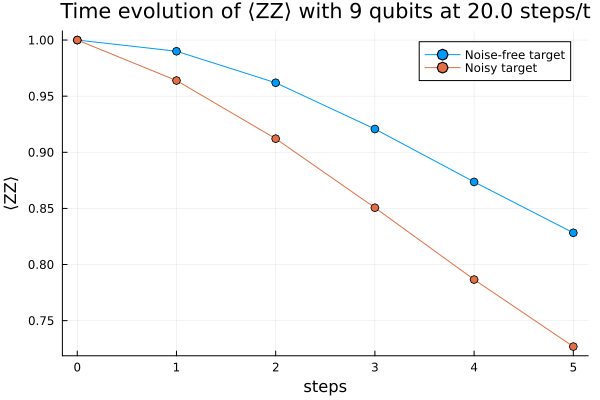

In [79]:
plot(0:trotter.steps, exact_expval_target, xlabel="steps", label="Noise-free target", marker=:o)
plot!(0:trotter.steps, noisy_expval_target, label="Noisy target", marker=:o)

if observable == obs_interaction(trotter)
    plot!(ylabel="⟨ZZ⟩", title = "Time evolution of ⟨ZZ⟩ with $(trotter.nqubits) qubits at $(trotter.steps/trotter.time) steps/t")
elseif observable == obs_magnetization(trotter)
    plot!(ylabel="⟨Z⟩",title = "Time evolution of ⟨Z⟩ with $(trotter.nqubits) qubits at $(trotter.steps/trotter.time) steps/t")
end

### Training data

In [80]:
#list_training_thetas = training_set_generation_brut(trotter, angle_definition; num_samples=10, non_replaced_gates=30);

In [81]:
#list_training_thetas = training_set_generation_strict_perturbation(trotter;sample_function = "small",num_samples=10);

In [82]:
list_training_thetas = training_set_generation_loose_perturbation(trotter;sample_function = "CPA",num_samples=10);

In [83]:
num_nonzero_entries = count(!iszero, list_training_thetas[1])
println("Number of non-zero entries: ", num_nonzero_entries)

Number of non-zero entries: 85


In [84]:
println(length(trotter.target_circuit))

85


In [85]:
exact_expvals = training_trotter_time_evolution(trotter, list_training_thetas; observable = observable, record=true);

In [86]:
noisy_expvals = training_trotter_time_evolution(trotter, list_training_thetas; observable = observable, noise_kind="realistic", record = true);

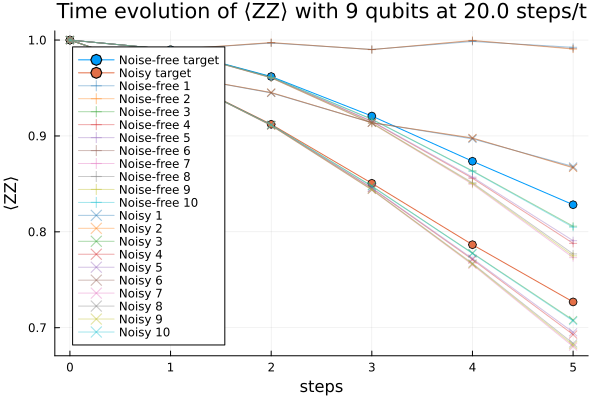

In [87]:
colors = palette(:tab10)

plot(0:trotter.steps, exact_expval_target, xlabel="steps", label="Noise-free target", marker=:o)
plot!(0:trotter.steps, noisy_expval_target, label="Noisy target", marker=:o)

for (i, exact) in enumerate(exact_expvals)
    plot!(0:trotter.steps, exact, label="Noise-free $(i)", c=colors[i], marker=:+, alpha = 0.4)
end

for (i, noisy) in enumerate(noisy_expvals)
    plot!(0:trotter.steps, noisy, label="Noisy $(i)", color=colors[i], marker=:x, alpha = 0.4)
end

if observable == obs_interaction(trotter)
    plot!(ylabel="⟨ZZ⟩", title = "Time evolution of ⟨ZZ⟩ with $(trotter.nqubits) qubits at $(trotter.steps/trotter.time) steps/t")
else
    plot!(ylabel="⟨Z⟩",title = "Time evolution of ⟨Z⟩ with $(trotter.nqubits) qubits at $(trotter.steps/trotter.time) steps/t")
end

In [88]:
exact_expvals_cdr = training_trotter_time_evolution(trotter, list_training_thetas; record=false);
noisy_expvals_cdr = training_trotter_time_evolution(trotter, list_training_thetas; noise_kind="realistic", record = false);
corr_energy, rel_error_after, rel_error_before = cdr(noisy_expvals_cdr, exact_expvals_cdr, noisy_expval_target[end], exact_expval_target[end])

[SubInfo] Noisy target expectation value: 0.7268629926774581
[SubInfo] Relative error before CDR: 0.12241951448821013
[SubInfo] CDR-EM target expectation value: 0.8276258078999837
[SubInfo] Relative error after CDR: 0.0007631897126302402


(0.8276258078999837, 0.0007631897126302402, 0.12241951448821013)

In [89]:
#check ooM of error as defined in Fig 4 CPA:
MSE = (corr_energy-exact_expval_target[end])^2 #this is noise independent

3.9957307540051086e-7

In [90]:
MSE_noise = (noisy_expval_target[end]-exact_expval_target[end])^2 #this is noise dependent

0.01028093246868

# CDR tests

### Full Run Test

In [ ]:
#now full run is set to the loose method
global_logger(UnbufferedLogger(stdout, SubInfo))

nq = 20
steps = 8
sigma_star = pi/20
T = 0.5
J = 2.0 #J > 0 in ferromagnetic phase, J < 0 in antiferromagnetic phase
h = 1.0 #abs(h) < abs(J) in ordered phase
trotter = trotter_setup(nq, steps, T, J, h);
noise_kind = "realistic" #takes the default realistic values
min_abs_coeff = 1e-3;
min_abs_coeff_noisy = min_abs_coeff;
#training_set = training_set_generation_loose_perturbation(trotter, sigma_star; sample_function = "CPA", num_samples=10);
#training_set = training_set_generation_brut(trotter, sigma_star; num_samples=10, non_replaced_gates=30);
full_run(trotter, sigma_star, noise_kind, min_abs_coeff, min_abs_coeff_noisy; observable = obs_magnetization(trotter))

[SubInfo] ready to ruuuuuummmble

## CPA plots for phases of TFIM
### Fig a)

In [43]:
#set noise
# noise_kind = "realistic"
depol_strength_double = 0.0033
dephase_strength_double = 0.0033
#leave these so we don't have to modify the code
# depol_strength = 0.00035
# dephase_strength = 0.00035
noise_kind = "gate"
depol_strength = 0.015
dephase_strength = 0.015

0.015

In [44]:
global_logger(UnbufferedLogger(stdout,MainInfo))
#CPA system
nq = 9 #20
steps = 5 #8
sigma_star = pi/20
T = 0.5
sigma_h = 0.01:0.135:1.51 #0.135
h = sigma_h*steps/(2*T)
sigma_J = 0.01:0.135:1.51  #0 to pi/2 #to take expecation val for MSE

min_abs_coeff = 1e-10;
min_abs_coeff_noisy = min_abs_coeff;
num_samples = 10

MSE_loose_CPA_exp_list = []
MSE_loose_CPA_ind_list = []
MSE_loose_small_exp_list = []
MSE_loose_small_ind_list = []
MSE_noise_exp_list = []
MSE_noise_ind_list = []
MSE_strict_CPA_exp_list = []
MSE_strict_CPA_ind_list = []
MSE_strict_small_exp_list = []
MSE_strict_small_ind_list = []
MSE_brut_exp_list = []
MSE_brut_ind_list = []


function run_method(trotter, training_set,sigma_star, noise_kind, min_abs_coeff, min_abs_coeff_noisy; num_samples=10, depol_strength=0.01, dephase_strength=0.01, depol_strength_double=0.0033, dephase_strength_double=0.0033)
    exact_expval_target, noisy_expval_target, corr_energy, rel_error_before, rel_error_after = full_run(trotter, sigma_star, noise_kind, min_abs_coeff, min_abs_coeff_noisy; observable = obs_magnetization(trotter), training_set = training_set, depol_strength=depol_strength, dephase_strength=dephase_strength,depol_strength_double = depol_strength_double, dephase_strength_double = dephase_strength_double);    
    MSE_ind = (exact_expval_target - corr_energy)^2
    return MSE_ind
end

# function run_method_gate(trotter, training_set,sigma_star, noise_kind, min_abs_coeff, min_abs_coeff_noisy; num_samples=10, depol_strength=depol_strength, dephase_strength=dephase_strength)#, depol_strength_double=depol_strength_double, dephase_strength_double=dephase_strength_double)
#     exact_expval_target, noisy_expval_target, corr_energy, rel_error_before, rel_error_after = full_run(trotter, sigma_star, noise_kind, min_abs_coeff, min_abs_coeff_noisy; observable = obs_magnetization(trotter), training_set = training_set, depol_strength=depol_strength, dephase_strength=dephase_strength)#,depol_strength_double = depol_strength_double, dephase_strength_double = dephase_strength_double);    
#     MSE_ind = (exact_expval_target - corr_energy)^2
#     return MSE_ind
# end

for sig_h in sigma_h 
    h = sig_h*steps/(2*T)
    for sig_J in sigma_J
        J = -sig_J*steps/(2*T)
        trotter = trotter_setup(nq, steps, T, sig_J, sig_h);
        training_set = training_set_generation_loose_perturbation(trotter, sigma_star; sample_function = "CPA", num_samples = num_samples);
        exact_expval_target, noisy_expval_target, corr_energy, rel_error_before, rel_error_after = full_run(trotter, sigma_star, noise_kind, min_abs_coeff, min_abs_coeff_noisy; observable = obs_magnetization(trotter), training_set = training_set, depol_strength=depol_strength, dephase_strength=dephase_strength, depol_strength_double=depol_strength_double, dephase_strength_double=dephase_strength_double);
        MSE_ind = (exact_expval_target - corr_energy)^2
        push!(MSE_loose_CPA_ind_list, MSE_ind)

        MSE_noise = (exact_expval_target - noisy_expval_target)^2
        push!(MSE_noise_ind_list, MSE_noise)

        training_set = training_set_generation_loose_perturbation(trotter, sigma_star; sample_function = "small", num_samples = num_samples);
        MSE_ind = run_method(trotter, training_set, sigma_star, noise_kind, min_abs_coeff, min_abs_coeff_noisy; num_samples=num_samples, depol_strength=depol_strength, dephase_strength=dephase_strength, depol_strength_double=depol_strength_double, dephase_strength_double=dephase_strength_double)
        push!(MSE_loose_small_ind_list, MSE_ind)

        training_set = training_set_generation_strict_perturbation(trotter, sigma_star; sample_function = "CPA", num_samples = num_samples);
        MSE_ind = run_method(trotter, training_set, sigma_star, noise_kind, min_abs_coeff, min_abs_coeff_noisy; num_samples=num_samples, depol_strength=depol_strength, dephase_strength=dephase_strength, depol_strength_double=depol_strength_double, dephase_strength_double=dephase_strength_double)
        push!(MSE_strict_CPA_ind_list, MSE_ind)
        
        training_set = training_set_generation_strict_perturbation(trotter, sigma_star; sample_function = "small", num_samples = num_samples);
        MSE_ind = run_method(trotter, training_set, sigma_star, noise_kind, min_abs_coeff, min_abs_coeff_noisy; num_samples=num_samples, depol_strength=depol_strength, dephase_strength=dephase_strength, depol_strength_double=depol_strength_double, dephase_strength_double=dephase_strength_double)
        push!(MSE_strict_small_ind_list, MSE_ind)

        training_set = training_set_generation_brut(trotter, sigma_star; num_samples = num_samples, non_replaced_gates=30);
        MSE_ind = run_method(trotter, training_set, sigma_star, noise_kind, min_abs_coeff, min_abs_coeff_noisy; num_samples=num_samples, depol_strength=depol_strength, dephase_strength=dephase_strength, depol_strength_double=depol_strength_double, dephase_strength_double=dephase_strength_double)
        push!(MSE_brut_ind_list, MSE_ind)

    end

    push!(MSE_loose_CPA_exp_list, MSE_loose_CPA_ind_list)
    push!(MSE_loose_small_exp_list, MSE_loose_small_ind_list)
    push!(MSE_strict_CPA_exp_list, MSE_strict_CPA_ind_list)
    push!(MSE_strict_small_exp_list, MSE_strict_small_ind_list)
    push!(MSE_brut_exp_list, MSE_brut_ind_list)
    push!(MSE_noise_exp_list, MSE_noise_ind_list)

    MSE_loose_CPA_ind_list = []
    MSE_loose_small_ind_list = []
    MSE_strict_CPA_ind_list = []
    MSE_strict_small_ind_list = []
    MSE_brut_ind_list = []
    MSE_noise_ind_list = []
end
MSE_loose_CPA_fig_a = []
MSE_loose_small_fig_a = []
MSE_strict_CPA_fig_a = []
MSE_strict_small_fig_a = []
MSE_brut_fig_a = []
MSE_noise_fig_a = []

for i in MSE_loose_CPA_exp_list
    MSE = mean(i)
    push!(MSE_loose_CPA_fig_a, MSE)
end
for i in MSE_loose_small_exp_list
    MSE = mean(i)
    push!(MSE_loose_small_fig_a, MSE)
end
for i in MSE_strict_CPA_exp_list
    MSE = mean(i)
    push!(MSE_strict_CPA_fig_a, MSE)
end
for i in MSE_strict_small_exp_list
    MSE = mean(i)
    push!(MSE_strict_small_fig_a, MSE)
end
for i in MSE_noise_exp_list
    MSE = mean(i)
    push!(MSE_noise_fig_a, MSE)
end
for i in MSE_brut_exp_list
    MSE = mean(i)
    push!(MSE_brut_fig_a, MSE)
end

[MainInfo] nq=9 noise=gate total run done in 0.01 s
[MainInfo] nq=9 noise=gate total run done in 0.01 s
[MainInfo] nq=9 noise=gate total run done in 0.57 s
[MainInfo] nq=9 noise=gate total run done in 0.05 s
[MainInfo] nq=9 noise=gate total run done in 0.01 s
[MainInfo] nq=9 noise=gate total run done in 0.01 s
[MainInfo] nq=9 noise=gate total run done in 0.01 s
[MainInfo] nq=9 noise=gate total run done in 0.34 s
[MainInfo] nq=9 noise=gate total run done in 0.04 s
[MainInfo] nq=9 noise=gate total run done in 0.0 s
[MainInfo] nq=9 noise=gate total run done in 0.01 s
[MainInfo] nq=9 noise=gate total run done in 0.01 s
[MainInfo] nq=9 noise=gate total run done in 0.41 s
[MainInfo] nq=9 noise=gate total run done in 0.04 s
[MainInfo] nq=9 noise=gate total run done in 0.0 s
[MainInfo] nq=9 noise=gate total run done in 0.01 s
[MainInfo] nq=9 noise=gate total run done in 0.01 s
[MainInfo] nq=9 noise=gate total run done in 0.54 s
[MainInfo] nq=9 noise=gate total run done in 0.04 s
[MainInfo] nq=

In [45]:
df = DataFrame( sigma_h = sigma_h,MSE_loose_small = MSE_loose_small_fig_a, MSE_loose_CPA = MSE_loose_CPA_fig_a,  MSE_strict_small = MSE_strict_small_fig_a, MSE_strict_CPA = MSE_strict_CPA_fig_a, MSE_brut = MSE_brut_fig_a, MSE_noise = MSE_noise_fig_a)
fn = format("data/Fig_4a_noise_type={:>2s}_T={:.2f}_angdef={:.2f}_steps={:n}_nqubits={:n}_nsamples={:n}_minabs={:.2e}_minabsnoisy={:.2e}_depol={:.2e}_dephase={:.2e}.csv",  
noise_kind,T, sigma_star, steps, nq, num_samples, min_abs_coeff, min_abs_coeff_noisy,depol_strength, dephase_strength)
CSV.write(fn, df)

"data/Fig_4a_noise_type=gate_T=0.50_angdef=0.16_steps=5_nqubits=9_nsamples=10_minabs=1.00e-10_minabsnoisy=1.00e-10_depol=1.50e-02_dephase=1.50e-02.csv"

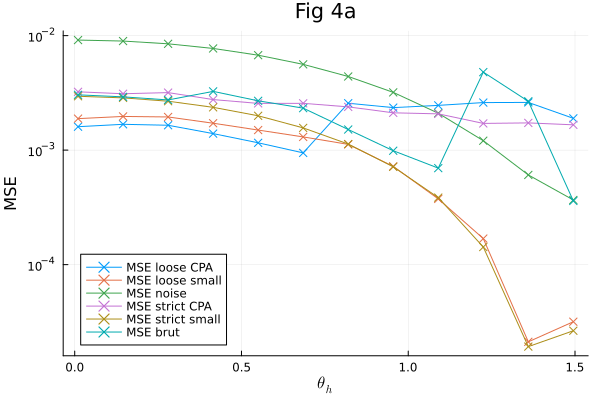

In [46]:
plot(sigma_h, MSE_loose_CPA_fig_a, yscale = :log10,  marker=:x, label="MSE loose CPA")
plot!(sigma_h, MSE_loose_small_fig_a, marker=:x, label="MSE loose small")
plot!(sigma_h, MSE_noise_fig_a, marker=:x, label="MSE noise")
plot!(sigma_h, MSE_strict_CPA_fig_a, marker=:x, label="MSE strict CPA")
plot!(sigma_h, MSE_strict_small_fig_a, marker=:x, label="MSE strict small")
plot!(sigma_h, MSE_brut_fig_a, marker=:x, label="MSE brut", xlabel=L"\theta_h", ylabel="MSE",legend=:bottomleft,title="Fig 4a")

### Fig b)

In [ ]:
global_logger(UnbufferedLogger(stdout,1000))
#CPA system
nq = 20
steps = 8
sigma_star = pi/20
T = 0.5
sigma_h = 0.01:0.51:1.51 #0.135
h = sigma_h*steps/(2*T)
sigma_J = 0.01:0.135:1.51  #0 to pi/2 #to take expecation val for MSE
min_abs_coeff = 1e-10;
min_abs_coeff_noisy = min_abs_coeff;
num_samples = 10

MSE_loose_CPA_exp_list = []
MSE_loose_CPA_ind_list = []
MSE_loose_small_exp_list = []
MSE_loose_small_ind_list = []
MSE_noise_exp_list = []
MSE_noise_ind_list = []
MSE_strict_CPA_exp_list = []
MSE_strict_CPA_ind_list = []
MSE_strict_small_exp_list = []
MSE_strict_small_ind_list = []
MSE_brut_exp_list = []
MSE_brut_ind_list = []

for sig_J in sigma_J 
    J = -sig_J*steps/(2*T)
    for sig_h in sigma_h
        h = sig_h*steps/(2*T)
        
        trotter = trotter_setup(nq, steps, T, sig_J, sig_h);
        training_set = training_set_generation_loose_perturbation(trotter, sigma_star; sample_function = "CPA", num_samples = num_samples);
        exact_expval_target, noisy_expval_target, corr_energy, rel_error_before, rel_error_after = full_run(trotter, sigma_star, noise_kind, min_abs_coeff, min_abs_coeff_noisy; observable = obs_magnetization(trotter), training_set = training_set, depol_strength=depol_strength, dephase_strength=dephase_strength, depol_strength_double=depol_strength_double, dephase_strength_double=dephase_strength_double);
        MSE_ind = (exact_expval_target - corr_energy)^2
        push!(MSE_loose_CPA_ind_list, MSE_ind)

        MSE_noise = (exact_expval_target - noisy_expval_target)^2
        push!(MSE_noise_ind_list, MSE_noise)

        training_set = training_set_generation_loose_perturbation(trotter, sigma_star; sample_function = "small", num_samples = num_samples);
        MSE_ind = run_method(trotter, training_set, sigma_star, noise_kind, min_abs_coeff, min_abs_coeff_noisy; num_samples=num_samples, depol_strength=depol_strength, dephase_strength=dephase_strength, depol_strength_double=depol_strength_double, dephase_strength_double=dephase_strength_double)
        push!(MSE_loose_small_ind_list, MSE_ind)

        training_set = training_set_generation_strict_perturbation(trotter, sigma_star; sample_function = "CPA", num_samples = num_samples);
        MSE_ind = run_method(trotter, training_set, sigma_star, noise_kind, min_abs_coeff, min_abs_coeff_noisy; num_samples=num_samples, depol_strength=depol_strength, dephase_strength=dephase_strength, depol_strength_double=depol_strength_double, dephase_strength_double=dephase_strength_double)
        push!(MSE_strict_CPA_ind_list, MSE_ind)
        
        training_set = training_set_generation_strict_perturbation(trotter, sigma_star; sample_function = "small", num_samples = num_samples);
        MSE_ind = run_method(trotter, training_set, sigma_star, noise_kind, min_abs_coeff, min_abs_coeff_noisy; num_samples=num_samples, depol_strength=depol_strength, dephase_strength=dephase_strength, depol_strength_double=depol_strength_double, dephase_strength_double=dephase_strength_double)
        push!(MSE_strict_small_ind_list, MSE_ind)

        training_set = training_set_generation_brut(trotter, sigma_star; num_samples = num_samples, non_replaced_gates=30);
        MSE_ind = run_method(trotter, training_set, sigma_star, noise_kind, min_abs_coeff, min_abs_coeff_noisy; num_samples=num_samples, depol_strength=depol_strength, dephase_strength=dephase_strength, depol_strength_double=depol_strength_double, dephase_strength_double=dephase_strength_double)
        push!(MSE_brut_ind_list, MSE_ind)

    end

    push!(MSE_loose_CPA_exp_list, MSE_loose_CPA_ind_list)
    push!(MSE_loose_small_exp_list, MSE_loose_small_ind_list)
    push!(MSE_strict_CPA_exp_list, MSE_strict_CPA_ind_list)
    push!(MSE_strict_small_exp_list, MSE_strict_small_ind_list)
    push!(MSE_brut_exp_list, MSE_brut_ind_list)
    push!(MSE_noise_exp_list, MSE_noise_ind_list)

    MSE_loose_CPA_ind_list = []
    MSE_loose_small_ind_list = []
    MSE_strict_CPA_ind_list = []
    MSE_strict_small_ind_list = []
    MSE_brut_ind_list = []
    MSE_noise_ind_list = []
end
MSE_loose_CPA_fig_b = []
MSE_loose_small_fig_b = []
MSE_strict_CPA_fig_b = []
MSE_strict_small_fig_b = []
MSE_brut_fig_b = []
MSE_noise_fig_b = []

for i in MSE_loose_CPA_exp_list
    MSE = mean(i)
    push!(MSE_loose_CPA_fig_b, MSE)
end
for i in MSE_loose_small_exp_list
    MSE = mean(i)
    push!(MSE_loose_small_fig_b, MSE)
end
for i in MSE_strict_CPA_exp_list
    MSE = mean(i)
    push!(MSE_strict_CPA_fig_b, MSE)
end
for i in MSE_strict_small_exp_list
    MSE = mean(i)
    push!(MSE_strict_small_fig_b, MSE)
end
for i in MSE_noise_exp_list
    MSE = mean(i)
    push!(MSE_noise_fig_b, MSE)
end
for i in MSE_brut_exp_list
    MSE = mean(i)
    push!(MSE_brut_fig_b, MSE)
end

In [55]:
function plot_MSE_csv_data(filename::String , xaxis::String)

    data = CSV.read(filename, DataFrame)

    if xaxis == "sigma_h"
        sigma = sigma_h
    elseif xaxis == "sigma_J"
        sigma = deepcopy(sigma_J)
    else
        error("xaxis should be either sigma_h or sigma_J")
    end

    println("data = ", data)
    plot(data.sigma, data.MSE_loose_CPA, yscale = :log10,  marker=:x, label="MSE loose CPA")
    plot!(data.sigma, data.MSE_loose_small, marker=:x, label="MSE loose small")
    plot!(data.sigma, data.MSE_noise, marker=:x, label="MSE noise")
    plot!(data.sigma, data.MSE_strict_CPA, marker=:x, label="MSE strict CPA")
    plot!(data.sigma, data.MSE_strict_small, marker=:x, label="MSE strict small")
    plot!(data.sigma, data.MSE_brut, marker=:x, label="MSE brut", xlabel=L"\theta_J", ylabel="MSE",legend=:bottomright)
end
# data=CSV.read("data/Fig_4b_noise_type={:>2s}_T={:.2f}_angdef={:.2f}_steps={:n}_nqubits={:n}_nsamples={:n}_minabs={:.2e}_minabsnoisy={:.2e}.csv", DataFrame)
# plot(data.sigma_J, data.MSE_loose_CPA, yscale = :log10,  marker=:x, label="MSE loose CPA")
# plot!(data.sigma_J, data.MSE_loose_small, marker=:x, label="MSE loose small")
# plot!(data.sigma_J, data.MSE_noise, marker=:x, label="MSE noise")
# plot!(data.sigma_J, data.MSE_strict_CPA, marker=:x, label="MSE strict CPA")
# plot!(data.sigma_J, data.MSE_strict_small, marker=:x, label="MSE strict small")
# plot!(data.sigma_J, data.MSE_brut, marker=:x, label="MSE brut", xlabel=L"\theta_J", ylabel="MSE",legend=:bottomright, title = "Fig 4b")

plot_MSE_csv_data("data/Fig_4b_noise_type=realistic_T=0.50_angdef=0.16_steps=5_nqubits=9_nsamples=10_minabs=1.00e-10_minabsnoisy=1.00e-10_depol=3.50e-04__double_3.30e-03_dephase=3.50e-04_double_3.30e-03.csv", "sigma_J")

UndefVarError: UndefVarError: `sigma_J` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [61]:
function plot_MSE_csv_data(filename::String, xaxis::String)
    data = CSV.read(filename, DataFrame)
    hasproperty(data, Symbol(xaxis)) || error("Column $xaxis not found in data")

    x = getproperty(data, Symbol(xaxis))

    plot(x, data.MSE_loose_CPA, yscale = :log10, marker = :x, label = "MSE loose CPA")
    plot!(x, data.MSE_loose_small, marker = :x, label = "MSE loose small")
    plot!(x, data.MSE_noise, marker = :x, label = "MSE noise")
    plot!(x, data.MSE_strict_CPA, marker = :x, label = "MSE strict CPA")
    plot!(x, data.MSE_strict_small, marker = :x, label = "MSE strict small")
    #plot!(x, data.MSE_brut, marker = :x, label = "MSE brut",
    #     xlabel = xaxis == "sigma_J" ? L"\theta_J" : L"\theta_h", ylabel = "MSE", legend = :bottomright)
    plot!(x, data.MSE_brut, marker = :x, label = "MSE brut",
         xlabel = xaxis == "sigma_J" ? L"\theta_J" : L"\theta_h", ylabel = "MSE", legend = xaxis == "sigma_J" ? :bottomright : :bottomleft)
end

plot_MSE_csv_data (generic function with 3 methods)

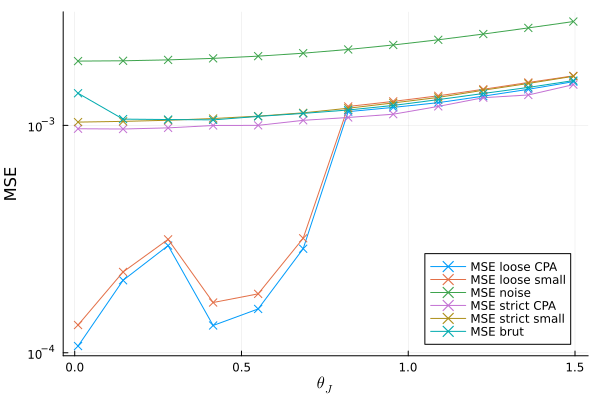

In [62]:
plot_MSE_csv_data("data/Fig_4b_noise_type=realistic_T=0.50_angdef=0.16_steps=5_nqubits=9_nsamples=10_minabs=1.00e-10_minabsnoisy=1.00e-10_depol=3.50e-04__double_3.30e-03_dephase=3.50e-04_double_3.30e-03.csv", "sigma_J")

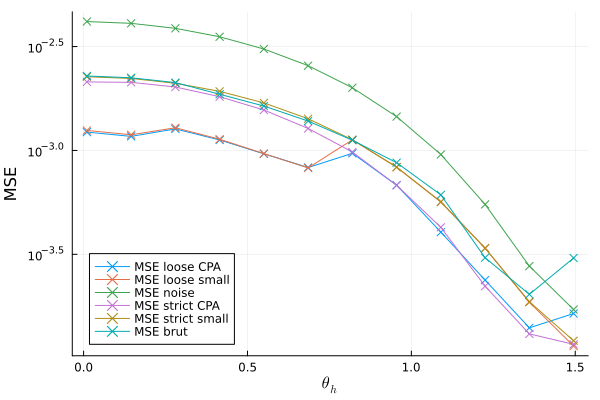

In [63]:
plot_MSE_csv_data("data/Fig_4a_noise_type=realistic_T=0.50_angdef=0.16_steps=5_nqubits=9_nsamples=10_minabs=1.00e-10_minabsnoisy=1.00e-10_depol=3.50e-04_double_3.30e-03_dephase=3.50e-04_double_3.30e-03.csv", "sigma_h")

In [ ]:
plot(sigma_J, MSE_loose_CPA_fig_b, yscale = :log10,  marker=:x, label="MSE loose CPA")
plot!(sigma_J, MSE_loose_small_fig_b, marker=:x, label="MSE loose small")
plot!(sigma_J, MSE_noise_fig_b, marker=:x, label="MSE noise")
plot!(sigma_J, MSE_strict_CPA_fig_b, marker=:x, label="MSE strict CPA")
plot!(sigma_J, MSE_strict_small_fig_b, marker=:x, label="MSE strict small")
plot!(sigma_J, MSE_brut_fig_b, marker=:x, label="MSE brut", xlabel=L"\theta_J", ylabel="MSE",legend=:bottomright, title = "Fig 4b")

In [ ]:
df = DataFrame( sigma_J = sigma_J,MSE_loose_small = MSE_loose_small_fig_b, MSE_loose_CPA = MSE_loose_CPA_fig_b,  MSE_strict_small = MSE_strict_small_fig_b, MSE_strict_CPA = MSE_strict_CPA_fig_b, MSE_brut = MSE_brut_fig_b, MSE_noise = MSE_noise_fig_b)
fn = format("data/Fig_4b_T={:.2f}_angdef={:.2f}_steps={:n}_nqubits={:n}_nsamples={:n}_minabs={:.2e}_minabsnoisy={:.2e}_depol={:.2e}_dephase={:.2e}.csv",  
T, sigma_star, steps, nq, num_samples, min_abs_coeff, min_abs_coeff_noisy,depol_strength, dephase_strength)
CSV.write(fn, df)